In [1]:
import numpy as np
import copy
from scipy.optimize import linear_sum_assignment

from keras.models import model_from_json
import keras
import pickle
import matplotlib.pyplot as plt
from itertools import product

C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Compare structures

### Extract saved WTs and random tickets

In [2]:
# function to get CNN from json and h5 files
def getModelFromFile(json_file, h5_file):
    # get model structure from json
    json = open(json_file, "r")
    loaded_json = json.read()
    json.close()
    model = model_from_json(loaded_json)
    
    # load weights in model
    model.load_weights(h5_file)
    return model

In [3]:
def is_WT(his_WT, his_orig):
    return (np.argmin(his_WT["val_loss"])<=np.argmin(his_orig["val_loss"])) and (np.min(his_WT["val_loss"])<1.02*np.min(his_orig["val_loss"]))

In [4]:
# array with WTs and with random tickets
WTs_CIFAR = []
WTs_CINIC = []
WTs_SVHN = []
randoms = []

# for each possible WT for CIFAR, add to array if it is one
for i in range(0, 20):
    # extract history
    his_orig = pickle.load(open('../tickets/WTs_CIFAR/his_orig_s0.1_nr' + str(i), "rb"))
    his_WT = pickle.load(open('../tickets/WTs_CIFAR/his_WT_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if is_WT(his_WT, his_orig):
        WTs_CIFAR.append(getModelFromFile("../tickets/conv2.json", "../tickets/WTs_CIFAR/WT_s0.1_nr" + str(i) + ".h5"))

#CINIC
for i in range(0, 20):
    # extract history
    his_orig = pickle.load(open('../tickets/WTs_CINIC/his_orig_s0.1_nr' + str(i), "rb"))
    his_WT = pickle.load(open('../tickets/WTs_CINIC/his_WT_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if is_WT(his_WT, his_orig):
        WTs_CINIC.append(getModelFromFile("../tickets/conv2.json", "../tickets/WTs_CINIC/WT_s0.1_nr" + str(i) + ".h5"))
        
#SVHN
for i in range(0, 20):
    # extract history
    his_orig = pickle.load(open('../tickets/WTs_SVHN/his_orig_s0.1_nr' + str(i), "rb"))
    his_WT = pickle.load(open('../tickets/WTs_SVHN/his_WT_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if is_WT(his_WT, his_orig):
        WTs_SVHN.append(getModelFromFile("../tickets/conv2.json", "../tickets/WTs_SVHN/WT_s0.1_nr" + str(i) + ".h5"))
        
        
# for each random ticket, add to array if it is not a WT
for i in range(0,20):
    # extract history
    his_orig = pickle.load(open('../tickets/random/his_orig_s0.1_nr' + str(i), "rb"))
    his_random = pickle.load(open('../tickets/random/his_random_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if not is_WT(his_random, his_orig):
        randoms.append(getModelFromFile("../tickets/conv2.json", "../tickets/random/random_s0.1_nr" + str(i) + ".h5"))
        
# take same amount of subnetworks for each condition (minimum of WTs of each type, in my case 14)  
min_len = min(len(randoms), len(WTs_SVHN), len(WTs_CIFAR), len(WTs_CINIC))

randoms = randoms[:min_len]
WTs_SVHN = WTs_SVHN[:min_len]
WTs_CIFAR = WTs_CIFAR[:min_len]
WTs_CINIC = WTs_CINIC[:min_len]

## Conv1 Layer

### Number of weights per 3x3x3 filter

group random
mean: 8.46875 std: 2.3478535505100946
group CIFAR-WTs
mean: 8.46875 std: 3.050381453020027
group CINIC-WTs
mean: 8.46875 std: 3.030191273135363
group SVHN-WTs
mean: 8.46875 std: 3.4497549408306836
group random [  0.   0.   0.   8.  26.  53.  96. 129. 172. 126. 101.  92.  52.  21.
  15.   3.   2.   0.   0.   0.   0.   0.]
group CIFAR-WTs [  0.   9.  15.  15.  36.  66.  98. 114. 120. 107.  88.  76.  57.  49.
  22.  12.  10.   1.   0.   1.   0.   0.]
group CINIC-WTs [  5.   2.   9.  25.  37.  66.  89. 120. 114.  96. 108.  87.  54.  35.
  28.  12.   4.   4.   0.   0.   0.   1.]
group SVHN-WTs [ 26.  33.  32.  13.  18.  30.  37.  76. 115. 133. 138.  95.  73.  41.
  22.   9.   3.   2.   0.   0.   0.   0.]


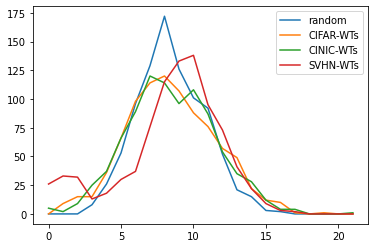

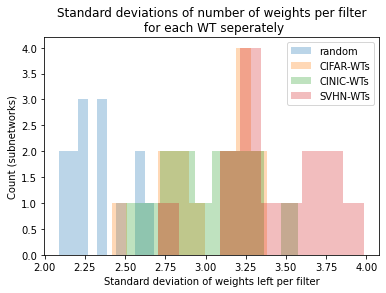

In [5]:
# get overview how many filters have one weight left, two etc. in 3x3x3 filter
w_left = np.zeros((64*14,4))

for nr, (name, group) in enumerate(zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN])):
    s = 0
    for ticket in group:
        for i in range(64):
            w_left[s,nr] = np.sum(np.array(ticket.layers[0].get_weights()[0])[:,:,:,i].flatten() != 0)
            s += 1
    
    print("group", name)
    print("mean:", np.mean(w_left[:,nr]), "std:", np.std(w_left[:,nr]))
    
# save to make plot with R
#np.savetxt("temp_files/nr_weights_per_filter.csv", w_left, delimiter = ",")


# count how many filters have x weights over
for nr, (name, group) in enumerate(zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN])):
    
    count = np.zeros((22))
    for ticket in group:
        # go through first layer and count how many filters have how many weights left 
        for i in range(64):
            nr_w = np.sum(np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,:,i] != 0))
            count[nr_w] += 1
    print("group", name, count)
    plt.plot(count, label = name)
    
plt.legend()
plt.show()


# std per ticket
w_left_sds = np.zeros((14,4))

for nr, (name, group) in enumerate(zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN])):
    s = 0
    for ticket in group:
        w_left = []
        for i in range(64):
            w_left.append(np.count_nonzero(np.array(ticket.layers[0].get_weights()[0])[:,:,:,i]))
        w_left_sds[s,nr] = np.std(w_left)
        s += 1
        
    plt.hist(w_left_sds[:,nr], alpha = 0.3, label = name)

plt.legend()
plt.title("Standard deviations of number of weights per filter\n for each WT seperately")
plt.xlabel("Standard deviation of weights left per filter")
plt.ylabel("Count (subnetworks)")
plt.show()


group random [ 84. 361. 683. 764. 501. 223.  57.  12.   3.   0.]
group CIFAR-WTs [141. 376. 643. 686. 478. 252.  89.  22.   1.   0.]
group CINIC-WTs [149. 367. 632. 689. 489. 264.  76.  18.   4.   0.]
group SVHN-WTs [248. 300. 544. 686. 529. 281.  81.  17.   2.   0.]


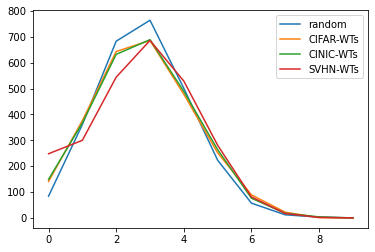

In [6]:
# get overview how many kernels have one weight left, two etc. in 3x3 kernel
# not distinguishing between color channels
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    count = np.zeros((10))
    for ticket in group:
        # go through first layer and count how many kernels have how many weights left (only 3x3)
        for i in range(64):
            for c in range(3):
                nr_w = np.sum(np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,c,i] != 0))
                count[nr_w] += 1
    print("group", name, count)
    plt.plot(count, label = name)
    
plt.legend()
plt.show()


### Position

group random

group CIFAR-WTs

group CINIC-WTs

group SVHN-WTs



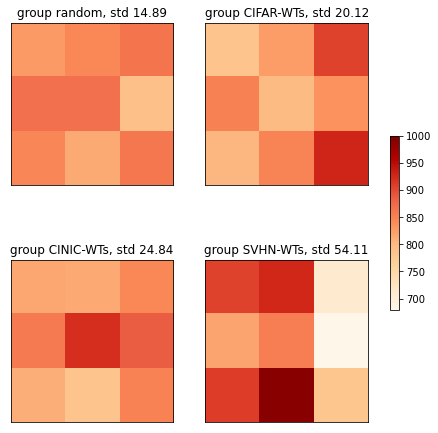

In [7]:
# count of how many weights in which position are left in 3x3 kernel, 
# not distinguishing between color channels
fig, ax = plt.subplots(2,2, figsize = (8,8))
pos = 0
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((3,3,3))
    print("group", name)

    for ticket in group:
        # go through first layer and always count leftover weights for each position
        for i in range(64):
            count += np.ceil(np.abs(np.array(ticket.layers[0].get_weights()[0])[:,:,:,i]))

    #print(np.sum(count, axis = 0))
    test = ax[int(pos/2),pos%2].imshow(np.sum(count, axis = 0), cmap = "OrRd", vmin=680, vmax=1000)
    ax[int(pos/2),pos%2].set_yticks(())
    ax[int(pos/2),pos%2].set_xticks(())
    ax[int(pos/2),pos%2].set_title("group " + name + ", std " + str(round(np.std(count.flatten()),2)))
    
    pos += 1
    print()
    
fig.colorbar(test, ax=ax[:, :], shrink = 0.4)
plt.show()


group random
281.037037037037 14.89
group CIFAR-WTs
281.037037037037 20.12
group CINIC-WTs
281.037037037037 24.84
group SVHN-WTs
281.037037037037 54.11


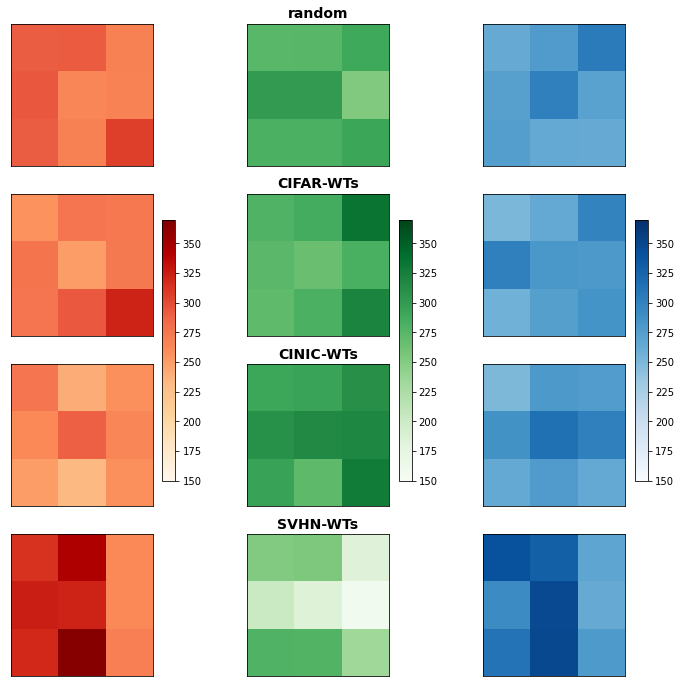

In [8]:
# count of how many weights in which position are left in 3x3x3 filter, 
# distinguishing (!) between color channels
fig, ax = plt.subplots(4,3, figsize = (12,12))
pos = 0
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((3,3,3))
    print("group", name)

    for ticket in group:
        # go through first layer and always count leftover weights for each position
        for i in range(64):
            count += np.array(ticket.layers[0].get_weights()[0])[:,:,:,i] != 0
    
    
    print(np.mean(count.flatten()),round(np.std(count.flatten()),2))
    col1 = ax[pos, 0].imshow(count[0], cmap = "OrRd", vmin=150, vmax=370)
    col2 = ax[pos, 1].imshow(count[1], cmap = "Greens", vmin=150, vmax=370)
    col3 = ax[pos, 2].imshow(count[2], cmap = "Blues", vmin=150, vmax=370)
    
    

    ax[pos,1].set_title(name, fontweight = "semibold", fontsize = 14)
    ax[pos,1].set_yticks(())
    ax[pos,2].set_yticks(())
    ax[pos,0].set_yticks(())
    ax[pos,1].set_xticks(())
    ax[pos,2].set_xticks(())
    ax[pos,0].set_xticks(())
    pos += 1


fig.colorbar(col1, ax=ax[:, 0], shrink = 0.4)
fig.colorbar(col2, ax=ax[:, 1], shrink = 0.4)
fig.colorbar(col3, ax=ax[:, 2], shrink = 0.4)    
plt.show()

### Signs

In [9]:
# count + and - weights per 3x3 kernel in first layer of WTs
print("Count of positive weights, count of negative weights, ratio of positive to negative weights")
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    print("group", name)
    signs_pos = 0
    signs_neg = 0
    for ticket in group:
        signs_pos += np.sum(np.array(ticket.layers[0].get_weights()[0])[:,:,:,:].flatten() > 0)
        signs_neg += np.sum(np.array(ticket.layers[0].get_weights()[0])[:,:,:,:].flatten() < 0)
    print("nr_pos:", signs_pos, "nr_neg:", signs_neg, "ratio:", signs_pos/signs_neg)
    


Count of positive weights, count of negative weights, ratio of positive to negative weights
group random
nr_pos: 3816 nr_neg: 3772 ratio: 1.0116648992576882
group CIFAR-WTs
nr_pos: 4905 nr_neg: 2683 ratio: 1.8281774133432724
group CINIC-WTs
nr_pos: 4632 nr_neg: 2956 ratio: 1.5669824086603519
group SVHN-WTs
nr_pos: 5077 nr_neg: 2511 ratio: 2.0219036240541617


### Patterns

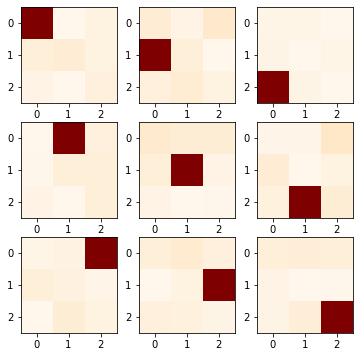

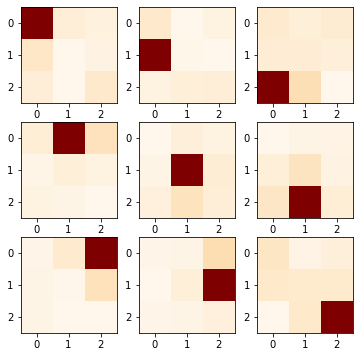

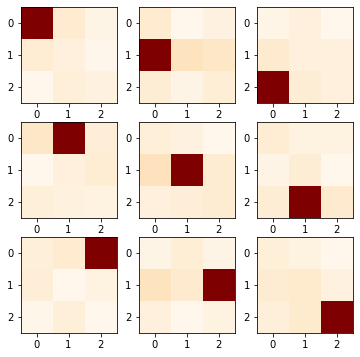

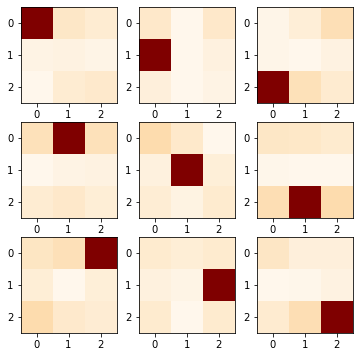

In [10]:
# look if certain combinations of kernel weights are especially often, not taking the signs into account
# not distinguishing between color channels
# NOT LOOKING AT SIGNS

# represent by 9x3x3 count, showing which combinations with the first pos (3,3) the second and so on
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((9,3,3))
    
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] != 0)
                if np.sum(weights) == 2:
                    for t in range(9):
                        if weights.flatten()[t] == 1:
                            count[t,:,:] += weights
                    
    #print(count)
    fig, ax = plt.subplots(3,3,figsize=(6,6))
    for i in range(9):
        ax[i%3,int(i/3)].imshow(count[i], cmap = "OrRd")
    plt.show()

Probability of a positive weight being present if a targeted positive weight is present
random


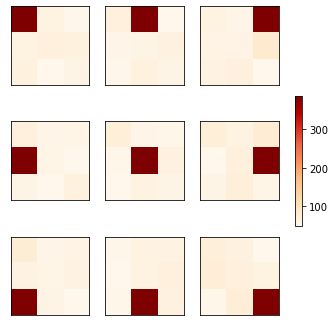

CIFAR-WTs


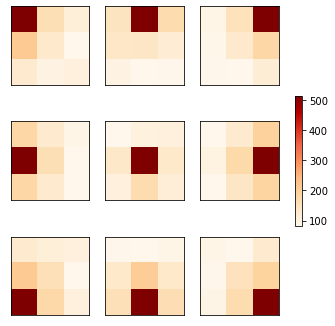

CINIC-WTs


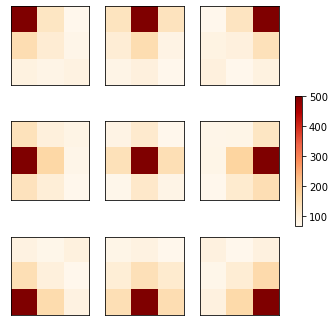

SVHN-WTs


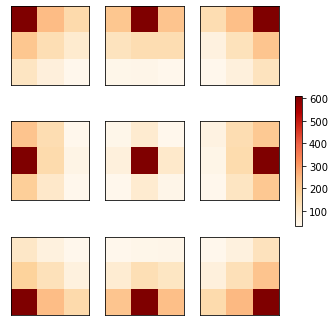

In [15]:
# look if certain combinations of kernel weights are especially often when taking the weights into account
# not distinguishing between color channels
# represent by 9x3x3 count, showing which combinations with the first pos (3,3) the second and so on

# POSITIVE_POSITIVE (only print for those)
print("Probability of a positive weight being present if a targeted positive weight is present")
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((9,3,3))
    
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] > 0)
                #weights_neg = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] < 0)
                for t in range(9):
                    if weights.flatten()[t] == 1:
                        count[t,:,:] += weights

    print(name)
    fig, ax = plt.subplots(3,3,figsize=(6,6))
    for i in range(9):
        pl = ax[int(i/3), i%3].imshow(count[i], cmap = "OrRd")
        ax[int(i/3), i%3].set_yticks(ticks = ())
        ax[int(i/3), i%3].set_xticks(ticks = ())
        
    fig.colorbar(pl, ax=ax[:, :], shrink = 0.4)
    plt.show()
    # for the SVHN WTs, save the nr of weights being at what position relative to the "targeted" position
    if name == "SVHN-WTs":
        with open('temp_files/SVHN_WTs_pos_pos', 'wb') as file_pi:
            pickle.dump(count.flatten(), file_pi)

            
# NEGATIVE_NEGATIVE
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((9,3,3))
    
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] < 0)
                #weights_neg = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] < 0)
                for t in range(9):
                    if weights.flatten()[t] == 1:
                        count[t,:,:] += weights

    # for the SVHN WTs, save the nr of weights being at what position relative to the "targeted" position
    if name == "SVHN-WTs":
        with open('temp_files/SVHN_WTs_neg_neg', 'wb') as file_pi:
            pickle.dump(count.flatten(), file_pi)

            
# POSITIVE_NEGATIVE
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((9,3,3))
    
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] > 0)
                weights_neg = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] < 0)
                for t in range(9):
                    if weights.flatten()[t] == 1:
                        count[t,:,:] += weights_neg

    # for the SVHN WTs, save the nr of weights being at what position relative to the "targeted" position
    if name == "SVHN-WTs":
        with open('temp_files/SVHN_WTs_pos_neg', 'wb') as file_pi:
            pickle.dump(count.flatten(), file_pi)
            
            

            
# NEGATIVE_POSITIVE
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((9,3,3))
    
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] > 0)
                weights_neg = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] < 0)
                for t in range(9):
                    if weights_neg.flatten()[t] == 1:
                        count[t,:,:] += weights


    # for the SVHN WTs, save the nr of weights being at what position relative to the "targeted" position
    if name == "SVHN-WTs":
        with open('temp_files/SVHN_WTs_neg_pos', 'wb') as file_pi:
            pickle.dump(count.flatten(), file_pi)
   

In [12]:
# normal percentage that two weights are neighbours, NEGATIVE
print("normal percentage:", 4/9 * 2/8 + 4/9 * 3/8 + 1/9 * 4/8) # 33,3%

# for two weights left:
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count_neighbours = 0
    count_global = 0
    
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] < 0)
                if np.sum(weights) == 2:
                    count_global += np.sum(range(np.sum(weights)))
                    if (weights.flatten()[0] == 1 and weights.flatten()[1] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[0] == 1 and weights.flatten()[3] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[1] == 1 and weights.flatten()[2] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[1] == 1 and weights.flatten()[4] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[2] == 1 and weights.flatten()[5] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[3] == 1 and weights.flatten()[4] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[3] == 1 and weights.flatten()[6] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[4] == 1 and weights.flatten()[5] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[4] == 1 and weights.flatten()[7] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[5] == 1 and weights.flatten()[8] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[6] == 1 and weights.flatten()[7] == 1):
                        count_neighbours += 1
                    if (weights.flatten()[7] == 1 and weights.flatten()[8] == 1):
                        count_neighbours += 1
    print(name, count_neighbours, count_global, "ratio:", count_neighbours/count_global)

normal percentage: 0.33333333333333337
random 221 693 ratio: 0.3189033189033189
CIFAR-WTs 312 515 ratio: 0.6058252427184466
CINIC-WTs 307 556 ratio: 0.552158273381295
SVHN-WTs 324 514 ratio: 0.6303501945525292


In [13]:
# normal percentage that two weights are neighbours, POSITIVE
print("normal percentage:", 4/9 * 2/8 + 4/9 * 3/8 + 1/9 * 4/8) # 33,3%

# for two weights left:
for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count_neighbours = 0
    count_global = 0
    
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] > 0)
                if np.sum(weights) == 2:
                    count_global += 1
                    if ((weights.flatten()[0] == 1 and weights.flatten()[1] == 1)
                        or (weights.flatten()[0] == 1 and weights.flatten()[3] == 1)
                        or (weights.flatten()[1] == 1 and weights.flatten()[2] == 1)
                        or (weights.flatten()[1] == 1 and weights.flatten()[4] == 1)
                        or (weights.flatten()[2] == 1 and weights.flatten()[5] == 1)
                        or (weights.flatten()[3] == 1 and weights.flatten()[4] == 1)
                        or (weights.flatten()[3] == 1 and weights.flatten()[6] == 1)
                        or (weights.flatten()[4] == 1 and weights.flatten()[5] == 1)
                        or (weights.flatten()[4] == 1 and weights.flatten()[7] == 1)
                        or (weights.flatten()[5] == 1 and weights.flatten()[8] == 1)
                        or (weights.flatten()[6] == 1 and weights.flatten()[7] == 1)
                        or (weights.flatten()[7] == 1 and weights.flatten()[8] == 1)):
                        count_neighbours += 1
    print(name, count_neighbours, count_global, "ratio:", count_neighbours/count_global)

normal percentage: 0.33333333333333337
random 241 732 ratio: 0.3292349726775956
CIFAR-WTs 376 670 ratio: 0.5611940298507463
CINIC-WTs 413 720 ratio: 0.5736111111111111
SVHN-WTs 512 787 ratio: 0.650571791613723


group random


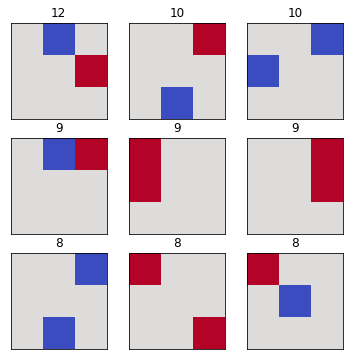

group CIFAR-WTs


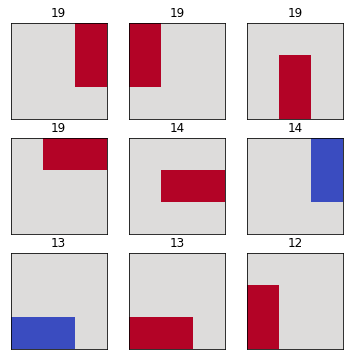

group CINIC-WTs


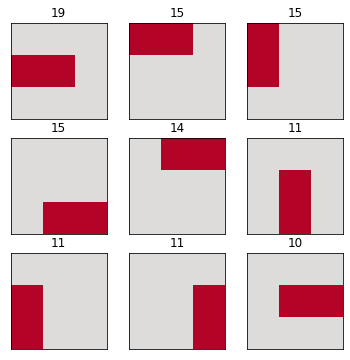

group SVHN-WTs


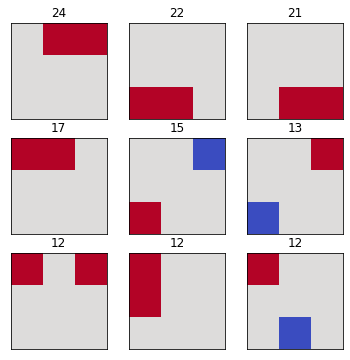

In [14]:
# look at filters with x weights, positive and negative 

############### PUT NUMBER OF WEIGHTS HERE #############################
weight_nr = 2
########################################################################

list_combs = []

for comb in list(product([1,0,-1], repeat = 9)):
    if np.sum(np.abs(comb)) == weight_nr:
        list_combs.append(comb)

for name, group in zip(["random", "CIFAR-WTs", "CINIC-WTs", "SVHN-WTs"],
                       [randoms, WTs_CIFAR, WTs_CINIC, WTs_SVHN]):
    
    count = np.zeros((len(list_combs)))
    
    print("group", name)
    for ticket in group:
        for kernel in range(64):
            for channel in range(3):
                weights = (np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] > 0) 
                           - np.int32(np.array(ticket.layers[0].get_weights()[0])[:,:,channel, kernel] < 0))
                if np.sum(np.abs(weights)) == weight_nr:
                    for i, comb in enumerate(list_combs):
                        if (comb == weights.flatten()).all():
                            count[i] += 1
                            break
    sorted_index_arr = np.argsort(count)[::-1]
    sorted_comb_arr = np.array(list_combs)[sorted_index_arr, :]

    fig, ax = plt.subplots(3,3,figsize=(6,6))
    for i in range(9):
        ax[int(i/3),i%3].imshow(sorted_comb_arr[i].reshape((3,3)), cmap = "coolwarm",vmin=-1, vmax=1)
        ax[int(i/3),i%3].set_yticks(ticks = ())
        ax[int(i/3),i%3].set_xticks(ticks = ())
        ax[int(i/3),i%3].set_title(str(int(count[sorted_index_arr][i])))
    plt.show()
